<a href="https://colab.research.google.com/github/mrbenbot/wimblepong/blob/main/Wimblepong_Reinforcement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Setup Google Colab Environment
%pip install gym
%pip install stable-baselines3[extra]
%pip install imageio pillow
%pip install tensorflowjs




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 24.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

DRIVE_PATH = "/content/drive/MyDrive/wimblepong"
DAY = "6-thursday"

Mounted at /content/drive


In [3]:
# Import necessary libraries
import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register

import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, VecCheckNan
from stable_baselines3.common.monitor import Monitor


from IPython import display

import os
import imageio
import glob
import math

from IPython.display import display, Image, HTML

import tensorflow as tf
from tensorflow.keras import layers
import torch as th
import numpy as np

import matplotlib.pyplot as plt

from moviepy.editor import ImageSequenceClip
import pygame


# Check versions
print("gym version:", gym.__version__)
print("stable-baselines3 version:", stable_baselines3.__version__)


  np.bool8: (False, True),

  from scipy.ndimage.filters import sobel



gym version: 0.29.1
stable-baselines3 version: 2.3.2


In [4]:
COURT_HEIGHT = 800
COURT_WIDTH = 1200
PADDLE_HEIGHT = 90
PADDLE_WIDTH = 15
BALL_RADIUS = 12
INITIAL_BALL_SPEED = 10
PADDLE_SPEED_DIVISOR = 15  # Example value, adjust as needed
PADDLE_CONTACT_SPEED_BOOST_DIVISOR = 4  # Example value, adjust as needed
SPEED_INCREMENT = 0.6  # Example value, adjust as needed
SERVING_HEIGHT_MULTIPLIER = 2  # Example value, adjust as needed
PLAYER_COLOURS = {'Player1': 'blue', 'Player2': 'red'}
MAX_COMPUTER_PADDLE_SPEED = 10

In [5]:
rewards_map = {
    "hit_paddle": lambda _: 50,
    "score_point": lambda _: 100,
    "conceed_point": lambda ball, paddle, rally_length: (-abs(ball['y'] - paddle['y']) / max(rally_length, 1)),
    # "conceed_point": lambda ball, paddle, rally_length: -0.1,
    "serve": lambda ball_speed: ball_speed / 10,
    "paddle_movement": lambda dy: 0,
    "ball_distance": lambda ball, paddle: 0
}

In [6]:
class Player:
    Player1 = 'Player1'
    Player2 = 'Player2'

class PlayerPositions:
    Initial = 'Initial'
    Reversed = 'Reversed'

class GameEventType:
    ResetBall = 'ResetBall'
    Serve = 'Serve'
    WallContact = 'WallContact'
    HitPaddle = 'HitPaddle'
    ScorePointLeft = 'ScorePointLeft'
    ScorePointRight = 'ScorePointRight'

def get_bounce_angle(paddle_y, paddle_height, ball_y):
    relative_intersect_y = (paddle_y + (paddle_height / 2)) - ball_y
    normalized_relative_intersect_y = relative_intersect_y / (paddle_height / 2)
    return normalized_relative_intersect_y * (math.pi / 4)

class CustomPongEnv(gym.Env):
    def __init__(self):
        super(CustomPongEnv, self).__init__()

        self.action_space = spaces.Box(low=np.array([0, -60]), high=np.array([1, 60]), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=np.array([0, 0, -np.inf, -np.inf, 0, 0, 0, 0], dtype=np.float32),
            high=np.array([COURT_WIDTH, COURT_HEIGHT, np.inf, np.inf, COURT_WIDTH, COURT_HEIGHT, 1, 1], dtype=np.float32)
        )
        self.starting_states = [
          #  {'server': Player.Player1, 'positions_reversed': False, 'opponent': Player.Player1, 'player': Player.Player2},
          #  {'server': Player.Player2, 'positions_reversed': True, 'opponent': Player.Player1, 'player': Player.Player2},
           {'server': Player.Player1, 'positions_reversed': True, 'opponent': Player.Player1, 'player': Player.Player2},
          #  {'server': Player.Player2, 'positions_reversed': False, 'opponent': Player.Player1, 'player': Player.Player2},
        ]

        self.starting_state_index = 0
        self.serve_delay = 50
        self.serve_delay_counter = 0
        self.direction = 15

        self.screen = None
        self.frame_count = 0
        self.last_event = None

        self.is_done = False
        self.reset(seed=0)

    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]

    def reset(self, seed=None):
        super().reset(seed=seed)
        if seed is not None:
            self.seed(seed)
        # print("Environment reset")
        starting_state = self.starting_states[self.starting_state_index]
        self.starting_state_index = (self.starting_state_index + 1) % len(self.starting_states)

        server = starting_state['server']
        positions_reversed = starting_state['positions_reversed']
        computer = starting_state['opponent']
        player = starting_state['player']

        self.game_state = {
            'server': server,
            'positions_reversed': positions_reversed,
            'opponent': computer,
            'player': player,
            Player.Player1: {'x': 0, 'y': COURT_HEIGHT // 2 - PADDLE_HEIGHT // 2, 'dy': 0, 'width': PADDLE_WIDTH, 'height': PADDLE_HEIGHT, 'colour': 'blue'},
            Player.Player2: {'x': COURT_WIDTH - PADDLE_WIDTH, 'y': COURT_HEIGHT // 2 - PADDLE_HEIGHT // 2, 'dy': 0, 'width': PADDLE_WIDTH, 'height': PADDLE_HEIGHT, 'colour': 'red'},
            'ball': {'x': COURT_WIDTH // 2, 'y': COURT_HEIGHT // 2, 'dx': INITIAL_BALL_SPEED, 'dy': INITIAL_BALL_SPEED, 'radius': BALL_RADIUS, 'speed': INITIAL_BALL_SPEED, 'serve_mode': True, 'score_mode': False, 'score_mode_timeout': 0},
            'stats': {'rally_length': 0, 'serve_speed': INITIAL_BALL_SPEED, 'server': server}
        }
        self.apply_meta_game_state()
        self.serve_delay_counter = 0
        self.direction = 30 * np.random.rand()
        self.serve_delay = 100 * np.random.rand()
        self.direction = self.direction if np.random.rand() > 0.5 else -self.direction

        self.step_count = 0

        self.is_done = False
        return self._get_obs(), {}

    def apply_meta_game_state(self):
        game_state = self.game_state
        serving_player = game_state['server']
        positions_reversed = game_state['positions_reversed']
        if serving_player == Player.Player1:
            self.game_state[Player.Player1]['height'] = PADDLE_HEIGHT * SERVING_HEIGHT_MULTIPLIER
            self.game_state[Player.Player2]['height'] = PADDLE_HEIGHT
        else:
            self.game_state[Player.Player1]['height'] = PADDLE_HEIGHT
            self.game_state[Player.Player2]['height'] = PADDLE_HEIGHT * SERVING_HEIGHT_MULTIPLIER
        if positions_reversed:
            self.game_state[Player.Player1]['x'] = COURT_WIDTH - PADDLE_WIDTH
            self.game_state[Player.Player2]['x'] = 0
        else:
            self.game_state[Player.Player1]['x'] = 0
            self.game_state[Player.Player2]['x'] = COURT_WIDTH - PADDLE_WIDTH
        ball = self.game_state['ball']
        server_is_left = (serving_player == Player.Player1 and not positions_reversed) or (serving_player == Player.Player2 and positions_reversed)
        ball['y'] = self.game_state[serving_player]['height'] / 2 + self.game_state[serving_player]['y']
        ball['x'] = self.game_state[serving_player]['width'] + ball['radius'] if server_is_left else COURT_WIDTH - self.game_state[serving_player]['width'] - ball['radius']
        ball['speed'] = INITIAL_BALL_SPEED
        ball['serve_mode'] = True
        ball['score_mode'] = False
        ball['score_mode_timeout'] = 0
        self.game_state['stats']['rally_length'] = 0

    def step(self, action):
        # print(f"Action taken: {action}")
        self.step_count += 1
        button_pressed = action[0] > 0.5
        paddle_direction = action[1]
        model_player_actions = {'button_pressed': button_pressed, 'paddle_direction': paddle_direction}
        computer_player_actions = self.get_computer_player_actions(self.game_state['opponent'])
        actions = {self.game_state['opponent']: computer_player_actions, self.game_state['player']: model_player_actions}
        reward = self.update_game_state(actions, 2.5)
        obs = self._get_obs()
        info = {}
        terminated = self.check_done()
        truncated = False
        return obs, reward, terminated, truncated, info

    def update_game_state(self, actions, delta_time):
        reward = 0
        game_state = self.game_state
        ball = game_state['ball']
        stats = game_state['stats']
        server = game_state['server']
        paddle_left, paddle_right = (game_state[Player.Player2], game_state[Player.Player1]) if game_state['positions_reversed'] else (game_state[Player.Player1], game_state[Player.Player2])
        model_is_left = (game_state['player'] == Player.Player1 and not game_state['positions_reversed']) or (game_state['player'] == Player.Player2 and game_state['positions_reversed'])
        if ball['score_mode']:
            self.is_done = True
            return 0.01
        elif ball['serve_mode']:
            serving_from_left = (server == Player.Player1 and not game_state['positions_reversed']) or (server == Player.Player2 and game_state['positions_reversed'])
            if serving_from_left:
                ball['x'] = game_state[server]['width'] + ball['radius']
            else:
                ball['x'] = COURT_WIDTH - game_state[server]['width'] - ball['radius']
            if actions[server]['button_pressed']:
                ball['speed'] = INITIAL_BALL_SPEED
                ball['dx'] = INITIAL_BALL_SPEED if serving_from_left else -INITIAL_BALL_SPEED
                ball['serve_mode'] = False
                stats['rally_length'] += 1
                stats['serve_speed'] = abs(ball['dy']) + abs(ball['dx'])
                stats['server'] = server
                if game_state['player'] == server:
                    reward += rewards_map['serve'](abs(ball['dy']) + abs(ball['dx']))
            ball['dy'] = (game_state[server]['y'] + game_state[server]['height'] / 2 - ball['y']) / PADDLE_SPEED_DIVISOR
            ball['y'] += ball['dy'] * delta_time
        else:
            ball['x'] += ball['dx'] * delta_time
            ball['y'] += ball['dy'] * delta_time
            if ball['y'] - ball['radius'] < 0:
                ball['dy'] = -ball['dy']
                ball['y'] = ball['radius']
            elif ball['y'] + ball['radius'] > COURT_HEIGHT:
                ball['dy'] = -ball['dy']
                ball['y'] = COURT_HEIGHT - ball['radius']
            if ball['x'] - ball['radius'] < paddle_left['x'] + paddle_left['width'] and ball['y'] + ball['radius'] > paddle_left['y'] and ball['y'] - ball['radius'] < paddle_left['y'] + paddle_left['height']:
                bounce_angle = get_bounce_angle(paddle_left['y'], paddle_left['height'], ball['y'])
                ball['dx'] = (ball['speed'] + abs(paddle_left['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * math.cos(bounce_angle)
                ball['dy'] = (ball['speed'] + abs(paddle_left['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * -math.sin(bounce_angle)
                ball['x'] = paddle_left['x'] + paddle_left['width'] + ball['radius']
                ball['speed'] += SPEED_INCREMENT
                stats['rally_length'] += 1
                if paddle_left == game_state['player']:
                    reward += rewards_map["hit_paddle"](stats['rally_length'])
            elif ball['x'] + ball['radius'] > paddle_right['x'] and ball['y'] + ball['radius'] > paddle_right['y'] and ball['y'] - ball['radius'] < paddle_right['y'] + paddle_right['height']:
                bounce_angle = get_bounce_angle(paddle_right['y'], paddle_right['height'], ball['y'])
                ball['dx'] = -(ball['speed'] + abs(paddle_right['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * math.cos(bounce_angle)
                ball['dy'] = (ball['speed'] + abs(paddle_right['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * -math.sin(bounce_angle)
                ball['x'] = paddle_right['x'] - ball['radius']
                ball['speed'] += SPEED_INCREMENT
                stats['rally_length'] += 1
                if paddle_right == game_state['player']:
                    reward += rewards_map["hit_paddle"](stats['rally_length'])
            if ball['x'] - ball['radius'] < 0:
                ball['score_mode'] = True
                if model_is_left:
                    reward += rewards_map['conceed_point'](ball, paddle_left, stats['rally_length'])
                else:
                    reward += rewards_map['score_point'](stats['rally_length'])
            elif ball['x'] + ball['radius'] > COURT_WIDTH:
                ball['score_mode'] = True
                if not model_is_left:
                    reward += rewards_map['conceed_point'](ball, paddle_right, stats['rally_length'])
                else:
                    reward += rewards_map['score_point'](stats['rally_length'])
        if game_state['positions_reversed']:
            game_state[Player.Player1]['dy'] = actions[Player.Player1]['paddle_direction']
            game_state[Player.Player2]['dy'] = -actions[Player.Player2]['paddle_direction']
        else:
            game_state[Player.Player1]['dy'] = -actions[Player.Player1]['paddle_direction']
            game_state[Player.Player2]['dy'] = actions[Player.Player2]['paddle_direction']
        game_state[Player.Player1]['y'] += game_state[Player.Player1]['dy'] * delta_time
        game_state[Player.Player2]['y'] += game_state[Player.Player2]['dy'] * delta_time
        if model_is_left:
            reward += rewards_map['paddle_movement'](abs(paddle_left['dy']))
        else:
            reward += rewards_map['paddle_movement'](abs(paddle_right['dy']))
        if paddle_left['y'] < 0:
            paddle_left['y'] = 0
        if paddle_left['y'] + paddle_left['height'] > COURT_HEIGHT:
            paddle_left['y'] = COURT_HEIGHT - paddle_left['height']
        if paddle_right['y'] < 0:
            paddle_right['y'] = 0
        if paddle_right['y'] + paddle_right['height'] > COURT_HEIGHT:
            paddle_right['y'] = COURT_HEIGHT - paddle_right['height']
        reward += 0.01 * stats['rally_length']
        return reward

    def get_computer_player_actions(self, player):
        state = self.game_state
        is_left = (player == Player.Player1 and not state['positions_reversed']) or (player == Player.Player2 and state['positions_reversed'])
        if state['ball']['score_mode']:
            return {'button_pressed': False, 'paddle_direction': 0}
        paddle = state[player]
        if state['ball']['serve_mode']:
            if paddle['y'] <= 0 or paddle['y'] + paddle['height'] >= COURT_HEIGHT:
                self.direction = -self.direction
            if self.serve_delay_counter > self.serve_delay:
                return {'button_pressed': True, 'paddle_direction': self.direction}
            else:
                self.serve_delay_counter += 1
                return {'button_pressed': False, 'paddle_direction': self.direction}
        if is_left:
            return {
                'button_pressed': False,
                'paddle_direction': self.bounded_value(
                    paddle['y'] - state['ball']['y'] + paddle['height'] / 4,
                    -MAX_COMPUTER_PADDLE_SPEED,
                    MAX_COMPUTER_PADDLE_SPEED
                )
            }
        else:
            return {
                'button_pressed': False,
                'paddle_direction': -self.bounded_value(
                    paddle['y'] - state['ball']['y'] + paddle['height'] / 4 ,
                    -MAX_COMPUTER_PADDLE_SPEED,
                    MAX_COMPUTER_PADDLE_SPEED
                )
            }

    def bounded_value(self, value, min_value, max_value):
        return max(min_value, min(max_value, value))

    def _get_obs(self):
        state = self.game_state
        player = state['player']
        is_server = 1 if self.game_state['server'] == player else 0
        paddle = state[player]
        obs = np.array([
            float(state['ball']['x']),
            float(state['ball']['y']),
            float(state['ball']['dx']),
            float(state['ball']['dy']),
            float(paddle['x']),
            float(paddle['y']),
            float(int(state['ball']['serve_mode'])),
            float(is_server),
        ], dtype=np.float32)
        return obs

    def check_done(self):
        if self.game_state['stats']['rally_length'] > 100:
            return True
        if self.step_count > 1000:
            return True
        return self.is_done

    def render(self, mode='human', close=False):
        if close:
            if pygame.get_init():
                pygame.quit()
            return

        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode((COURT_WIDTH, COURT_HEIGHT))
        if not os.path.exists('./frames'):
            os.makedirs("./frames")

        # Clear screen
        self.screen.fill((255, 255, 255))  # Fill with white background
        state = self.game_state
        # Render paddles
        paddle1 = state[Player.Player1]
        paddle2 = state[Player.Player2]
        pygame.draw.rect(self.screen, paddle1['colour'], (paddle1['x'], paddle1['y'], paddle1['width'], paddle1['height']))
        pygame.draw.rect(self.screen, paddle2['colour'], (paddle2['x'], paddle2['y'], paddle2['width'], paddle2['height']))

        # Render ball
        ball = state['ball']
        pygame.draw.circle(self.screen, (0, 0, 0), (ball['x'], ball['y']), ball['radius'])

        # Update the display
        pygame.display.flip()

        # Save frame as image
        frame_path = f'./frames/frame_{self.frame_count:04d}.png'
        pygame.image.save(self.screen, frame_path)
        self.frame_count += 1


    def close(self):
        if not os.path.exists('./frames'):
            print("No frames directory found, skipping video creation.")
            return
        image_files = [f"./frames/frame_{i:04d}.png" for i in range(self.frame_count)]

        # Create a video clip from the image sequence
        clip = ImageSequenceClip(image_files, fps=24)  # 24 frames per second

        # Write the video file
        clip.write_videofile("./game_video.mp4", codec="libx264")
        pygame.quit()
        frames_dir = "./frames"
        if os.path.exists(frames_dir):
            for filename in os.listdir(frames_dir):
                file_path = os.path.join(frames_dir, filename)
                if os.path.isfile(file_path):
                    os.unlink(file_path)
            os.rmdir(frames_dir)


register(
    id='CustomPongEnv-v0',
    entry_point='__main__:CustomPongEnv',  # This entry point should match your custom environment class
)


In [7]:
# Create and test vectorised environment
# Create a vectorized environment
env = DummyVecEnv([lambda: gym.make('CustomPongEnv-v0') for _ in range(1)])  # Adjust number of instances as needed
env = VecNormalize(env, norm_obs=True, norm_reward=True)  # Normalize observations and rewards
# env = VecCheckNan(env, raise_exception=True)  # Wrap with VecCheckNan to detect NaNs


obs = env.reset()
print("Initial observation:", obs)

for i in range(10000000):
    action = env.action_space.sample()  # Sample random action
    print("Action taken:", action)
    obs, reward, done, info = env.step([action for _ in range(1)])
    print("Observation:", obs)
    print("Reward:", reward)
    print('iteration:', i)
    print("Done:", done)
    if np.any(done):
        obs = env.reset()
        break
        print("Environment reset")

env.close()

  logger.deprecation(



Initial observation: [[0.01       0.00999997 0.00995036 0.00995036 0.         0.00999996
  0.00707071 0.        ]]
Action taken: [ 0.8282336 18.14778  ]
Observation: [[ 0.00707107  0.00707105  0.00703597 -0.999949    0.         -0.99397427
   0.00499969  0.        ]]
Reward: [0.]
iteration: 0
Done: [False]
Action taken: [  0.5639987 -57.280445 ]
Observation: [[ 0.0057735   0.8229626   0.00574484 -0.52322984  0.          1.3439206
   0.00408214  0.        ]]
Reward: [0.]
iteration: 1
Done: [False]
Action taken: [  0.5399142 -27.077219 ]
Observation: [[ 0.005       1.4517182   0.00497518 -0.1971278   0.          1.3474191
   0.00353516  0.        ]]
Reward: [0.]
iteration: 2
Done: [False]
Action taken: [ 0.9643562 23.3147   ]
Observation: [[0.00447213 1.6718895  0.00444993 0.07512181 0.         0.5504365
  0.00316187 0.        ]]
Reward: [0.]
iteration: 3
Done: [False]
Action taken: [  0.19304404 -49.277435  ]
Observation: [[0.00408248 1.7642368  0.00406221 0.3046841  0.         1.477877

In [8]:

# Create and test single environment
env = Monitor(CustomPongEnv())

obs = env.reset()
print("Initial observation:", obs)

for i in range(1000):
    action = env.action_space.sample()  # Sample random action
    obs, reward, done, info, _ = env.step(action)
    print("Action taken:", action)
    print("Observation:", obs)
    print("Reward:", reward)
    print('iteration:', i)
    print("Done:", done)
    env.render()
    if done:
        obs = env.reset()
        print("Environment reset")
        break

env.close()

Initial observation: (array([1.173e+03, 4.450e+02, 1.000e+01, 1.000e+01, 0.000e+00, 3.550e+02,
       1.000e+00, 0.000e+00], dtype=float32), {})
Action taken: [ 0.234057 45.87425 ]
Observation: [1.1730000e+03 4.4500000e+02 1.0000000e+01 0.0000000e+00 0.0000000e+00
 2.4031438e+02 1.0000000e+00 0.0000000e+00]
Reward: 0.0
iteration: 0
Done: False
Action taken: [ 0.26528174 37.21364   ]
Observation: [1.1730000e+03 4.5313940e+02 1.0000000e+01 3.2557576e+00 0.0000000e+00
 1.4728029e+02 1.0000000e+00 0.0000000e+00]
Reward: 0.0
iteration: 1
Done: False
Action taken: [ 0.0913955 41.281696 ]
Observation: [1.1730000e+03 4.6806161e+02 1.0000000e+01 5.9688888e+00 0.0000000e+00
 4.4076042e+01 1.0000000e+00 0.0000000e+00]
Reward: 0.0
iteration: 2
Done: False
Action taken: [  0.6630683 -22.510214 ]
Observation: [1.1730000e+03 4.8863620e+02 1.0000000e+01 8.2298317e+00 0.0000000e+00
 1.0035158e+02 1.0000000e+00 0.0000000e+00]
Reward: 0.0
iteration: 3
Done: False
Action taken: [  0.08742023 -34.556503  ]

  size = imread(sequence[0]).shape



Action taken: [  0.9238107 -16.280554 ]
Observation: [ 23.       568.7924   -10.        14.847797   0.       474.885
   0.         0.      ]
Reward: 0.01
iteration: 128
Done: False
Action taken: [  0.49105346 -54.15518   ]
Observation: [ -2.       605.9119   -10.        14.847797   0.       610.27295
   0.         0.      ]
Reward: -131.01691455104856
iteration: 129
Done: False
Action taken: [ 0.4890698 -0.569245 ]
Observation: [ -2.       605.9119   -10.        14.847797   0.       610.27295
   0.         0.      ]
Reward: 0.01
iteration: 130
Done: True
Environment reset
Moviepy - Building video ./game_video.mp4.
Moviepy - Writing video ./game_video.mp4



Moviepy - Done !
Moviepy - video ready ./game_video.mp4


In [9]:

class CustomEvalCallback(EvalCallback):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mean_rewards = []

    def _on_step(self) -> bool:
        result = super()._on_step()
        if self.n_calls % self.eval_freq == 0:
            print(f"Evaluation at step {self.n_calls}: mean reward {self.last_mean_reward:.2f}")
            self.mean_rewards.append(self.last_mean_reward)
        return result

  logger.deprecation(



Using cpu device
Eval num_timesteps=8000, episode_reward=-2.54 +/- 0.68
Episode length: 68.00 +/- 11.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 68       |
|    mean_reward     | -2.54    |
| time/              |          |
|    total_timesteps | 8000     |
---------------------------------
New best mean reward!
Evaluation at step 2000: mean reward -2.54
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 118      |
|    ep_rew_mean     | -1.17    |
| time/              |          |
|    fps             | 2147     |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 8192     |
---------------------------------
Eval num_timesteps=16000, episode_reward=-1.71 +/- 0.92
Episode length: 83.80 +/- 23.01
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 83.8       |
|    mean_reward          | -1.71      |
|

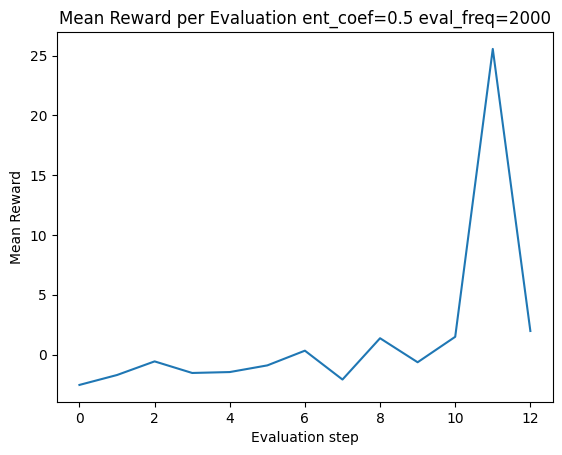

In [ ]:

# Create and train
ent_coef=0.5
eval_freq=2000
# Create vectorized environments for training and evaluation
train_env = DummyVecEnv([lambda: Monitor(gym.make('CustomPongEnv-v0')) for _ in range(4)])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True)

eval_env = DummyVecEnv([lambda: Monitor(gym.make('CustomPongEnv-v0'))])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False)

# Create the CustomEvalCallback
eval_callback = CustomEvalCallback(eval_env, best_model_save_path=f'{DRIVE_PATH}/{DAY}/logs/best_model',
                                   log_path=f'{DRIVE_PATH}/{DAY}/logs/results', eval_freq=eval_freq,
                                   deterministic=True, render=False)

# Train the model with the callback
model = PPO('MlpPolicy', train_env, verbose=1, ent_coef=ent_coef)
# model = PPO.load("ppo_custom_pong")
model.learn(total_timesteps=100000, callback=eval_callback)

# Save the model and the normalization statistics
model.save(f"{DRIVE_PATH}/{DAY}/ppo_custom_pong_1")
train_env.save(f"{DRIVE_PATH}/{DAY}/vecnormalize.pkl")

print("Training completed and logs are saved.")

# Plot the mean rewards
plt.plot(eval_callback.mean_rewards)
plt.xlabel('Evaluation step')
plt.ylabel('Mean Reward')
plt.title(f'Mean Reward per Evaluation {ent_coef=} {eval_freq=}')
plt.show()

Eval num_timesteps=8000, episode_reward=-84.46 +/- 115.27
Episode length: 128.80 +/- 39.27
---------------------------------
| eval/              |          |
|    mean_ep_length  | 129      |
|    mean_reward     | -84.5    |
| time/              |          |
|    total_timesteps | 8000     |
---------------------------------
New best mean reward!
Evaluation at step 2000: mean reward -84.46
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 113      |
|    ep_rew_mean     | -275     |
| time/              |          |
|    fps             | 2629     |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 8192     |
---------------------------------
Eval num_timesteps=16000, episode_reward=-55.49 +/- 114.04
Episode length: 131.00 +/- 70.79
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 131         |
|    mean_reward          | -55.5       |
| tim

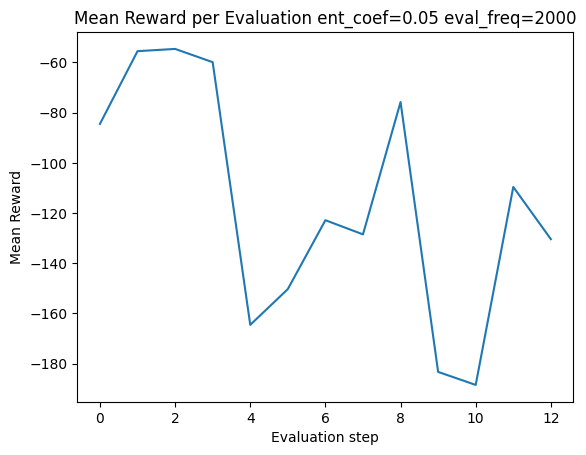

In [ ]:
# Load and train
ent_coef=0.05
eval_freq=2000
# Load the trained model and ensure the training environment is wrapped with VecNormalize
train_env = DummyVecEnv([lambda: Monitor(gym.make('CustomPongEnv-v0')) for _ in range(4)])
train_env = VecNormalize.load(f"{DRIVE_PATH}/{DAY}/vecnormalize.pkl", train_env)
train_env.training = True  # Ensure it's in training mode

# Create the evaluation environment and wrap it with VecNormalize
eval_env = DummyVecEnv([lambda: Monitor(gym.make('CustomPongEnv-v0'))])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False)
eval_env.training = False  # Ensure it's not in training mode

# Sync normalization statistics from the training environment to the evaluation environment
eval_env.obs_rms = train_env.obs_rms
eval_env.ret_rms = train_env.ret_rms

# Create the CustomEvalCallback with the evaluation environment
eval_callback = CustomEvalCallback(eval_env, best_model_save_path=f'{DRIVE_PATH}/{DAY}/logs/best_model',
                                   log_path=f'{DRIVE_PATH}/{DAY}/logs/results', eval_freq=eval_freq,
                                   deterministic=True, render=False)

# Load the pre-trained model
model = PPO.load(f"{DRIVE_PATH}/{DAY}/ppo_custom_pong_1", env=train_env, ent_coef=ent_coef)

# Resume training the model with the callback
model.learn(total_timesteps=100000, callback=eval_callback)

# Save the model and the normalization statistics
model.save(f"{DRIVE_PATH}/{DAY}/ppo_custom_pong_1")
train_env.save(f"{DRIVE_PATH}/{DAY}/vecnormalize.pkl")

print("Training completed and logs are saved.")

# Plot the mean rewards
plt.plot(eval_callback.mean_rewards)
plt.xlabel('Evaluation step')
plt.ylabel('Mean Reward')
plt.title(f'Mean Reward per Evaluation {ent_coef=} {eval_freq=}')
plt.show()

In [10]:
model = PPO.load(f"{DRIVE_PATH}/{DAY}/ppo_custom_pong_1")
# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

Mean reward: -78.79866129999999 +/- 133.82650038538142


In [12]:
# Load the trained model and evaluate
model = PPO.load(f"{DRIVE_PATH}/{DAY}/ppo_custom_pong_1")

# Create a new environment for rendering
eval_env = DummyVecEnv([lambda: Monitor(gym.make('CustomPongEnv-v0'))])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False)
eval_env.training = False  # Ensure we're not in training mode to prevent normalization updates
eval_env.norm_reward = False  # Disable reward normalization for evaluation

# Load the normalization statistics
train_env = DummyVecEnv([lambda: Monitor(gym.make('CustomPongEnv-v0'))])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True)
train_env = VecNormalize.load(f"{DRIVE_PATH}/{DAY}/vecnormalize.pkl", train_env)

# Sync the observation normalization statistics
eval_env.obs_rms = train_env.obs_rms

# Extract the first environment from the vectorized environment
env = eval_env.envs[0]

# Run a simple loop to demonstrate rendering with the trained model
obs = eval_env.reset()
count = 0

while count < 4:
    action, _states = model.predict(obs, deterministic=True)  # Get action from the trained model
    obs, reward, done, info = eval_env.step(action)
    env.render()
    if done:
      count += 1
      print("reset")
      obs = eval_env.reset()

env.close()

reset
reset
reset
reset
Moviepy - Building video ./game_video.mp4.
Moviepy - Writing video ./game_video.mp4



Moviepy - Done !
Moviepy - video ready ./game_video.mp4


In [13]:
# Load the VecNormalize wrapper
env = DummyVecEnv([lambda: gym.make('CustomPongEnv-v0')])
env = VecNormalize.load(f"{DRIVE_PATH}/{DAY}/vecnormalize.pkl", env)

# Extract normalization parameters
mean = env.obs_rms.mean
std = env.obs_rms.var ** 0.5

# Save the mean and std to a file
import json
normalization_params = {'mean': mean.tolist(), 'std': std.tolist()}
with open('normalization_params.json', 'w') as f:
    json.dump(normalization_params, f)

In [14]:
# Load the trained model
model = PPO.load(f"{DRIVE_PATH}/{DAY}/ppo_custom_pong_1")

# Print the model architecture
print(model.policy)

# Extract the policy network
policy = model.policy

# Print the state dictionary keys to understand the structure
for name, param in policy.state_dict().items():
    print(name, param.shape)

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=8, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=8, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=2, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)
log_std torch.Size([2])
mlp_extractor.policy_net.0.weight torch.Size([64, 8])
mlp_extractor.policy_net.0.bias torch.Size([64])
mlp_ext

In [15]:
# Define the TensorFlow model structure
@tf.keras.utils.register_keras_serializable()
class CustomPongModel(tf.keras.Model):
    def __init__(self):
        super(CustomPongModel, self).__init__()
        self.dense1_policy = tf.keras.layers.Dense(64, activation='tanh')
        self.dense2_policy = tf.keras.layers.Dense(64, activation='tanh')
        self.dense1_value = tf.keras.layers.Dense(64, activation='tanh')
        self.dense2_value = tf.keras.layers.Dense(64, activation='tanh')
        self.action = tf.keras.layers.Dense(2)
        self.value = tf.keras.layers.Dense(1)

    def call(self, x):
        # Policy network
        pi_x = self.dense1_policy(x)
        pi_x = self.dense2_policy(pi_x)
        action = self.action(pi_x)

        # Value network
        vf_x = self.dense1_value(x)
        vf_x = self.dense2_value(vf_x)
        value = self.value(vf_x)

        return action, value

# Instantiate the TensorFlow model
tf_model = CustomPongModel()


In [17]:
import torch
import pickle
from stable_baselines3 import PPO

# Load the trained PyTorch model
model = PPO.load(f"{DRIVE_PATH}/{DAY}/ppo_custom_pong_1")

# need to run once to initialise model
dummy_input = np.random.randn(1, 8).astype(np.float32)  # Assuming input size is 8
tf_model(dummy_input)

# Extract the policy network
policy = model.policy

# Extract the weights and biases
weights = {}
for name, param in policy.state_dict().items():
    weights[name] = param.cpu().numpy()

# Map the weights to the TensorFlow model
# Note: Transpose the weights because PyTorch uses [out_features, in_features] and TensorFlow uses [in_features, out_features]

# Policy network
tf_model.dense1_policy.set_weights([weights['mlp_extractor.policy_net.0.weight'].T, weights['mlp_extractor.policy_net.0.bias']])
tf_model.dense2_policy.set_weights([weights['mlp_extractor.policy_net.2.weight'].T, weights['mlp_extractor.policy_net.2.bias']])

# Value network
tf_model.dense1_value.set_weights([weights['mlp_extractor.value_net.0.weight'].T, weights['mlp_extractor.value_net.0.bias']])
tf_model.dense2_value.set_weights([weights['mlp_extractor.value_net.2.weight'].T, weights['mlp_extractor.value_net.2.bias']])

# Action and value outputs
tf_model.action.set_weights([weights['action_net.weight'].T, weights['action_net.bias']])
tf_model.value.set_weights([weights['value_net.weight'].T, weights['value_net.bias']])


In [20]:
# tf_model.save("tf_custom_pong_model.keras")
saved_model_path = "./saved_model"
tf.saved_model.save(tf_model, saved_model_path)

In [21]:
# Convert TensorFlow to TensorFlow.js
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model ./saved_model ./tfjs_model

2024-06-07 08:00:36.654914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
